# **Projet de MAP568**
**1, Introduction**

**2 Modèle SEIR**

2.1 Les compartiments

2.2 L’évolution de l’épidémie

$\frac{dS}{dt}=-\tau SI^-$

$\frac{dI^-}{dt}=\tau S I^--\lambda_1 I^--(\gamma_{IR}+\gamma_{IH}+\gamma_{IU})I^+$

$\frac{dR^-}{dt}=\gamma_{IR}I^--\lambda_2 R^-$

$\frac{dR^{+^I}}{dt}=\gamma_{IR}I^++\lambda_2 R^-$

$\frac{dH}{dt}=\gamma_{IH}(I^-+I^+)-(\gamma_{HR}+\gamma_{HD}+\gamma_{HU})H$

$\frac{dU}{dt}=\gamma_{IU}(I^-+I^+)+\gamma_{HU}H-(\gamma_{UR}+\gamma_{UD})U$

$\frac{dR^{+^H}}{dt}=\gamma_{HR}H+\gamma_{UR}U$

$\frac{dD}{dt}=\gamma_{UD}U+\gamma_{HD}H$

**2.3 Les paramètres**

$\tau(t)=\tau_0 exp(-\mu \times max(t-N,0))$

 $p_a$: la probabilité pour un individu infecté d’être asymptomatique

  $p_{IH}$ la probabilité pour un individu infecté
symptomatique de devoir être hospitalisé (et passer en compartiment H)


$p_{IU}$ la probabilité pour un individu infecté symptomatique de devoir être admis directement en soins intensifs (et passer en compartiment U).

 $N_I$ le
nombre moyen de jours pasés dans les compartiments $I^−$ ou $I^+$.

$\gamma_{IR}=\frac{p_a+(1-p_a)(1-p_{IH}-p_{IU})}{N_I}$

$\gamma_{IH}=\frac{(1-p_a)p_{IH}}{N_I}$

$\gamma_{IU}=\frac{(1-p_a)p_{IU}}{N_1}$

$\gamma_{HD}=\frac{p_{HD}}{N_H}$

$\gamma_{HU}=\frac{p_{HU}}{N_H}$

$\gamma_{HR}=\frac{1-p_{HD}-p_{HU}}{N_H}$

$\gamma_{UD}=\frac{p_{UD}}{N_U}$

$\gamma_{UR}=\frac{1-p_{UD}}{N_U}$

$\tau_0=\frac{R_0(\lambda_1+\gamma_{IR}+\gamma_{IH}+\gamma_{IU})}{S_0}$

**3 Propagation d’incertitudes**


3.1 Incertitudes en entrée


3.2 Incertitudes en sortie

*Question 1:*




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def create_points(N):
    """
    Creates a set X of N points returns a matrix of dimensions (N,15)
    """
    min = np.array([0.4,0.05,0.01,0.1,0.1,0.2,8,15,10,2.9,0.01,1,10**(-4)])
    max = np.array([0.9,0.2,0.04,0.2,0.2,0.4,12,25,20,3.4,0.08,100,10**(-3)])
    pa,pIH,pIU,pHD,pHU,pUD,N1,NH,NU,R0,mu,I0,lambda1=np.transpose(np.random.uniform(min,max,size=(N,13)))
    t0=np.random.choice(a=np.arange(0,31),p=None,size=N)#début épidémie
    N=np.random.choice(a=np.arange(31,51),p=None,size=N)
    return np.array([pa,pIH,pIU,pHD,pHU,pUD,N1,NH,NU,R0,mu,I0,lambda1,t0,N]).T

def solve(X,M):
    """
    résout le système d'équation pour l'ensemble de points X sur M pas de temps.
    Renvoie les trajectoires de tous les paramètres de sortie
    """
    S0=67 *10**(6)
    lambda2 = 0
    N = np.shape(X)[0]
    gamma_IR=(X[:,0]+(1-X[:,0])*(1-X[:,1]-X[:,2]))/X[:,6]
    gamma_IH=(1-X[:,0])*X[:,1]/X[:,6]
    gamma_IU=(1-X[:,0])*X[:,2]/X[:,6]
    gamma_HD=X[:,3]/X[:,7]
    gamma_HU=X[:,4]/X[:,7]
    gamma_HR=(1-X[:,3]-X[:,4])/X[:,7]
    gamma_UD=X[:,5]/X[:,8]
    gamma_UR=(1-X[:,5])/X[:,8]
    tau0=X[:,9]*(X[:,12]+gamma_IR+gamma_IH+gamma_IU)/S0
    t=np.arange(0,M)
    tau=np.ones((N,M))
    N_days = X[:,14]-X[:,13]
    for i in range(N):
        tau[i,:]=tau0[i]*np.exp(-X[:,10][i]*np.maximum(t-N_days[i],0))
        
    S=S0*np.ones((N,M))
    I=np.array([X[i,11]*np.ones((N,M))[i] for i in range(N)])
    I_plus=np.zeros((N,M))
    R_=np.zeros((N,M))
    R_plus=np.zeros((N,M))
    H=np.zeros((N,M))
    U=np.zeros((N,M))
    R_plusH=np.zeros((N,M))
    D=np.zeros((N,M))
    DR=np.zeros((N,M))
    for n in range(1,M):
        S[:,n]=(1-tau[:,n-1]*I[:,n-1])*S[:,n-1]
        I[:,n]=(1+tau[:,n-1]*S[:,n-1]-X[:,12]-(gamma_IR+gamma_IH+gamma_IU))*I[:,n-1]
        I_plus[:,n]=X[:,12]*I[:,n-1]-(-1+gamma_IR+gamma_IH+gamma_IU)*I_plus[:,n-1]
        R_[:,n]=gamma_IR*I[:,n-1]+(1-lambda2)*R_[:,n-1]
        R_plus[:,n]=gamma_IR*I_plus[:,n-1]+R_plus[:,n-1]+lambda2*R_[:,n-1]
        H[:,n]=gamma_IH*(I[:,n-1]+I_plus[:,n-1])-(-1+gamma_HR+gamma_HD+gamma_HU)*H[:,n-1]
        U[:,n]=gamma_IU*(I[:,n-1]+I_plus[:,n-1])-(-1+gamma_UR+gamma_UD)*U[:,n-1]+gamma_HU*H[:,n-1]
        R_plusH[:,n]=gamma_HR*H[:,n-1]+gamma_UR*U[:,n-1]+R_plusH[:,n-1]
        D[:,n]=gamma_UD*U[:,n-1]+gamma_HD*H[:,n-1]+D[:,n-1]
        DR[:,n]=(X[:,12]+gamma_IH+gamma_IU)*I[:,n-1]
    
    
    return S,I,I_plus,R_,R_plus,H,U,R_plusH,D,DR

def get_dates(X,U):
    """
    from the set of points X and the solution variables  U 
    Returns the dates : 
    date_t0 = dates du début épidémie
    date_N = dates de la prise d'effets des mesures
    date_max = dates du pic de l'épidémie
    range_date = suite des dates dans le segment [date_début,date_début + M]
    """
    N = np.shape(X)[0]
    M = np.shape(U)[1]
    min_t0 = pd.to_datetime("25/01/2020")
    max_N = pd.to_datetime("15/03/2020")
    range_t0_N = pd.date_range(min_t0,max_N)
    max_U = np.argmax(U,axis=1)
    
    date_t0 = []
    date_N = []
    date_max = []
    range_dates = []
    for i in range(N):
        start_date =  range_t0_N[np.int(X[i,13])]
        date_t0.append(start_date) 
        date_N.append(range_t0_N[np.int(X[i,14])])
        range_dates.append(pd.date_range(start = start_date,periods=M,freq="D"))
        date_max.append(start_date+np.timedelta64(max_U[i],"D"))
    
    return date_t0,date_N,range_dates,date_max    

In [3]:
N = 1000
M = 200
X = create_points(N)
S,I,I_plus,R_,R_plus,H,U,R_plusH,D,DR = solve(X,M)

In [4]:
date_t0,date_N,range_dates,date_max = get_dates(X,U)

Le début de l'épidémie a lieu le 2020-02-06
Le nombre maximal de patients présents en soins intensif est  921.0  personnes et ce maximum est atteint le 2020-04-08 soit jours après le début


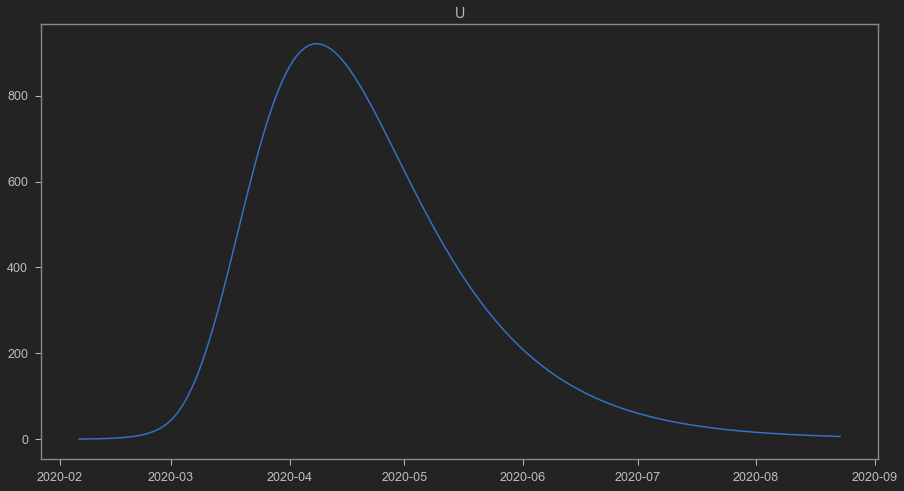

In [5]:
chose_sim =832 #for plots
start_date = date_t0[chose_sim]
range_date = range_dates[chose_sim]
fig = plt.figure(figsize=(15,8))
fig =plt.plot(range_date,U[chose_sim],label ="Nombre de personnes en soins intensifs")
fig= plt.title("U")
print("Le début de l'épidémie a lieu le",start_date.date())
print("Le nombre maximal de patients présents en soins intensif est ", np.floor(np.max(U[chose_sim]))," personnes et ce maximum est atteint le", date_max[chose_sim].date(), "soit", "jours après le début")

Question 2

a/ Loi du Nombre maximal de patients présents en soins intensifs

In [6]:
Max=np.max(U,axis=1)
print('Moyenne du nombre maximal de patients présents en soins intensifs:',int(np.mean(Max)), 'personnes')

Moyenne du nombre maximal de patients présents en soins intensifs: 20213 personnes


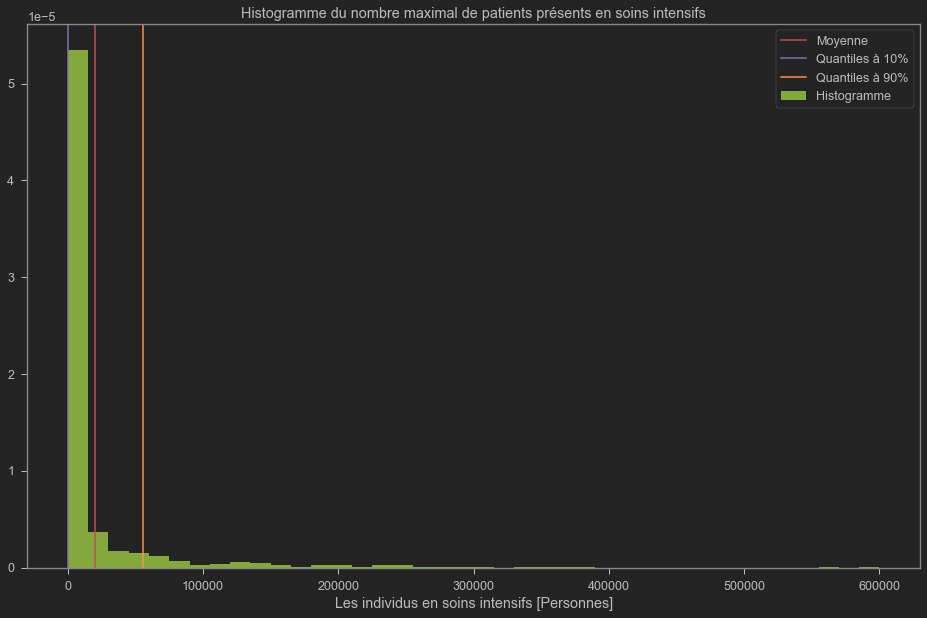

In [7]:
plt.figure(figsize=(16,10))
plt.hist(Max,bins=40,density=True,color='C1',label='Histogramme')
plt.xlabel("Les individus en soins intensifs [Personnes]")
plt.title('Histogramme du nombre maximal de patients présents en soins intensifs')
plt.axvline(np.mean(Max),color='C2',label='Moyenne')
plt.axvline(np.quantile(Max,0.1),color='C3',label='Quantiles à 10%')
plt.axvline(np.quantile(Max,0.9),color='C4',label='Quantiles à 90%')
plt.legend()
plt.show()

b/loi de la date du pic de l'épidémie

le pic de l'épidémie a lieu en moyenne le 2020-04-20


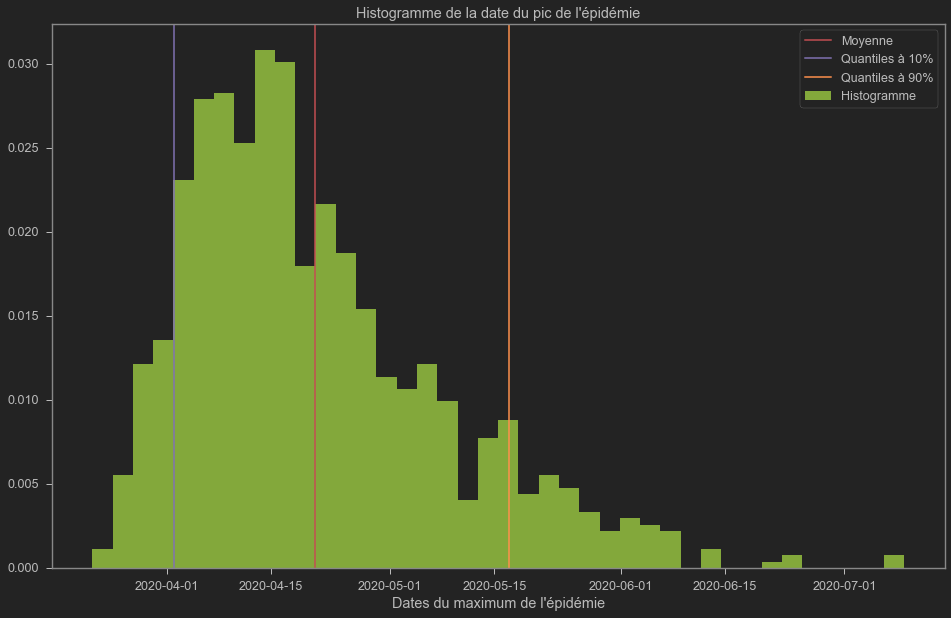

In [8]:
df_date_max = pd.DataFrame(data = date_max,columns=["date_max"])
max_date_mean = df_date_max["date_max"].mean()
print("le pic de l'épidémie a lieu en moyenne le",max_date_mean.date())
q_90 = pd.to_datetime(df_date_max["date_max"].quantile(.9, interpolation='nearest'))
q_10 = pd.to_datetime(df_date_max["date_max"].quantile(.1, interpolation='nearest'))
plt.figure(figsize=(16,10))
plt.hist(df_date_max["date_max"],bins=40,density=True,color='C1',label='Histogramme')
plt.xlabel("Dates du maximum de l'épidémie")
plt.title("Histogramme de la date du pic de l'épidémie")
plt.axvline(max_date_mean,color='C2',label='Moyenne')
plt.axvline(q_10,color='C3',label='Quantiles à 10%')
plt.axvline(q_90,color='C4',label='Quantiles à 90%')
plt.legend()
plt.show()

# Analyse de sensibilité

## Analyse par la méthode de Morris

Le code est très rapide à faire tourner donc on a pas besoin de faire le problème adjoint. On va faire la méthode de Morris par Monte-Carlo Simple.

In [59]:
R = 1000 #R de Morris:
M=200
lambda_2 = 0.
mini = np.array([0.4,0.05,0.01,0.1,0.1,0.2,8,15,10,2.9,0.01,1,10**(-4),1,32])
delta = mini/1000 #delta adapté à la dimension étudiée
dim = 15 #Nombre de paramètres d'entrée
S_maxima = np.zeros((R,dim)) #on ve y stocker tous les indices de la méthode OAT
S_date  = np.zeros((R,dim))

#on tire R points selon les bonnes distributions:
I = np.eye(dim)
X = create_points(R)
for d in range(dim):
    e_d = I[d]
    X_derived = X+delta[d]*e_d
    U = solve(X,M)[6]
    U_derived = solve(X_derived,M)[6]
    U_max = np.max(U,axis=1)
    U_derived_max = np.max(U_derived,axis=1)
    S_maxima[:,d]=(U_derived_max-U_max)/delta[d]

In [60]:
mu_maxima = np.sum(np.abs(S_maxima),axis = 0)/R
mean_S = np.sum(S_maxima,axis = 0)/R
sigma_maxima = np.sqrt((1./(R-1))*np.sum((S_maxima-mean_S)**2,axis =0))

In [61]:
sigma_maxima

array([1.35246100e+05, 1.41999474e+05, 1.33514978e+06, 9.36228390e-08,
       1.26731222e+05, 1.69414092e-07, 2.27960009e+04, 4.98588937e+02,
       2.53304698e+03, 1.02053012e+05, 4.82714938e+06, 7.93447113e+02,
       1.84665440e+06, 3.83510582e+03, 3.65616792e+03])

In [62]:
mu_maxima

array([5.63946568e+04, 5.55024218e+04, 5.19566791e+05, 1.53710533e-08,
       4.72830143e+04, 4.03322024e-08, 1.10288836e+04, 1.72097542e+02,
       9.93249732e+02, 5.15381966e+04, 1.87457831e+06, 2.48887397e+02,
       9.41502423e+05, 1.93778047e+03, 1.85908361e+03])

L'analyse de sensibilité pour le maximum de patients en réanimation par la méthode de Morris nous montre que les paramètres : pHD et pUD appartiennent au groupe avec effets négligeables.
Tous les autres paramètres appartiennent au groupe avec effets non-linéaires et/ou interactions.

## Analyse de Sensibilité par la méthode de Sobol

### Indices de premier ordre
Les indices de Sobol $S_i$ sont tels que 
$$S_i = \frac{D_i}{D}=\frac{Var(E[Y|X_i])}{Var(Y)}=\frac{Cov(Y,Y_i)}{Var(Y)}$$

In [98]:
N=1000
dim =15
S = np.zeros(dim) #indices simples
S_T = np.zeros(dim) #indices totaux
X=create_points(N)
for d in range(dim):
    X_tilde =create_points(N) #pour les indices simples
    X_T = np.copy(X) #pour les indices totaux
    X_T[:,d] = X_tilde[:,d]
    X_tilde[:,d]=X[:,d]
    Y = np.max(solve(X,200)[6],axis=1)
    Y_tilde = np.max(solve(X_tilde,200)[6],axis=1)
    Y_T = np.max(solve(X_T,200)[6],axis=1)
    cov = np.cov(Y,Y_tilde)[0][1] #empirical covariance
    var_Y = np.var(Y)
    S[d]=cov/var_Y
    S_T[d] = (1/N)*np.sum((Y-Y_T)**2)/(2*var_Y)

In [100]:
S

array([-0.0084731 ,  0.01397526, -0.0212665 , -0.00193137, -0.04291542,
       -0.00148448,  0.02786192,  0.01177087, -0.00142629,  0.00524305,
        0.26405203,  0.00221418,  0.03974249,  0.07661349,  0.00856883])

In [99]:
S_T

array([1.60181252e-01, 2.03588624e-02, 5.64698809e-02, 2.23611537e-32,
       6.91069672e-03, 3.67831660e-31, 2.07313537e-01, 7.36821531e-04,
       1.76593180e-02, 9.42235603e-02, 5.01036169e-01, 4.95917777e-02,
       9.09126580e-05, 3.77051049e-01, 1.25617950e-01])